## This notebook will investigate the implementation of a DQN to train an agent on the ALE Tetris environment.

#### Imports

In [2]:
import gymnasium as gym
import numpy as np
import ale_py
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

## First, let's check out the observations returned in the environment. 

Step 250 observation, uncropped and cropped:


A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


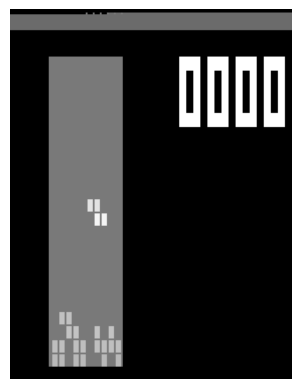

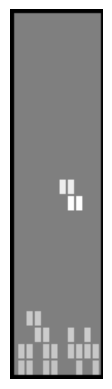

In [2]:
env = gym.make("ALE/Tetris-v5", obs_type="grayscale")
state, _ = env.reset()

total_steps = 500
observation_check = 250

for step in range(total_steps):
    cropped_state = state[25:-5, 20:-95]
    if step % observation_check == 0 and step != 0:
        print(f"Step {step} observation, uncropped and cropped:")
        
        plt.imshow(state, cmap="gray")
        plt.axis('off')
        plt.show()

        plt.imshow(cropped_state, cmap="gray")
        plt.axis('off')
        plt.show()
        
    action = env.action_space.sample()
    next_state, _, done, _, _ = env.step(action)
    if done:
        print(f"Game over at step {step}")
        next_state, _ = env.reset()
    
    state = next_state

env.close()

## Baseline random agent

In [10]:
max_ep = 100
episode= 0
env = gym.make("ALE/Tetris-v5", obs_type="rgb")


steps_random = []

total_steps = 100

while episode < max_ep:
    curr_step = 0
    state, _ = env.reset()
    while True:
        action = env.action_space.sample()

        next_state, _, done, _, _ = env.step(action)
        curr_step += 1
        if done:
            episode += 1
            steps_random.append(curr_step)
            break

    state = next_state

env.close()

## Using the reward provided in the ALE, train a DQN Agent

#### The DQN, Agent

In [3]:
GAMMA = 0.90
LR = 1e-3
BATCH_SIZE = 32
GAME_OVER_PENALTY = -100
MEMORY_SIZE = 10000
EPSILON_END = 0.05
EPSILON_START = 1.0
EPSILON_DECAY = 0.99
TARGET_UPDATE = 1000
MAX_STEPS_PER_EPISODE = 5000
NUM_EPISODES = 50
STAY_ALIVE_BONUS = 1

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = EPSILON_START
        self.action_dim = action_dim
        self.steps = 0
    
    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.policy_net(state)).item()
    
    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def train(self):
        if len(self.memory) < BATCH_SIZE:
            return
    
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float32, device=self.device)

        q_values = self.policy_net(states)
        q_values = torch.gather(q_values, 1, actions).squeeze()

        with torch.no_grad():
            next_q_values = self.target_net(next_states)
            max_next_q_values = torch.max(next_q_values, dim=1)[0]

        target_q_values = rewards + (1 - dones) * GAMMA * max_next_q_values
        
        loss = nn.MSELoss()(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(EPSILON_END, EPSILON_START - self.steps * EPSILON_DECAY)

        if self.steps % TARGET_UPDATE == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

### Train

In [15]:
env = gym.make("ALE/Tetris-v5", obs_type="grayscale")

def crop_state(state):
    return state[25:-5, 20:-95]
    
initial_state, _ = env.reset()
cropped_state = crop_state(initial_state)
state_dim = cropped_state.shape[0] * cropped_state.shape[1]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim)
rewards_simple = []
steps_simple = []

for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    state = crop_state(state)
    episode_reward = 0
    step_count = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = crop_state(next_state)

        agent.store_experience(state, action, reward, next_state, done)
        agent.train()

        episode_reward += reward
        agent.steps += 1
        step_count += 1
        state = next_state

        if done or step_count >= MAX_STEPS_PER_EPISODE:
            rewards_simple.append(episode_reward)
            steps_simple.append(step_count)
            break

print("Training is complete.")

torch.save(agent.policy_net.state_dict(), "dqn_tetris_simple.pth")
env.close()

Training is complete.


## Evaluate the model

In [16]:
agent = DQNAgent(state_dim, action_dim)

agent.policy_net.load_state_dict(torch.load("dqn_tetris_simple.pth"))
agent.policy_net.eval()

episode = 0
max_ep = 100
steps_run_simple = []
reward_run_simple = []

while episode < max_ep:
    state, _ = env.reset()
    state = crop_state(state)
    episode_reward = 0
    step_count = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = crop_state(next_state)
        
        episode_reward += reward
        step_count += 1
        state = next_state

        if done:
            steps_run_simple.append(step_count)
            reward_run_simple.append(episode_reward)
            episode += 1
            break
    
    print(f"Episode {episode}: {episode_reward} reward and {step_count} steps.")

    env.close()

Episode 1: 0.0 reward and 368 steps.
Episode 2: 0.0 reward and 426 steps.
Episode 3: 0.0 reward and 637 steps.
Episode 4: 0.0 reward and 598 steps.
Episode 5: 0.0 reward and 490 steps.
Episode 6: 1.0 reward and 621 steps.
Episode 7: 0.0 reward and 498 steps.
Episode 8: 0.0 reward and 821 steps.
Episode 9: 0.0 reward and 493 steps.
Episode 10: 0.0 reward and 633 steps.
Episode 11: 0.0 reward and 699 steps.
Episode 12: 0.0 reward and 487 steps.
Episode 13: 0.0 reward and 664 steps.
Episode 14: 0.0 reward and 477 steps.
Episode 15: 0.0 reward and 597 steps.
Episode 16: 0.0 reward and 589 steps.
Episode 17: 0.0 reward and 576 steps.
Episode 18: 0.0 reward and 352 steps.
Episode 19: 0.0 reward and 401 steps.
Episode 20: 0.0 reward and 722 steps.
Episode 21: 0.0 reward and 558 steps.
Episode 22: 0.0 reward and 478 steps.
Episode 23: 0.0 reward and 419 steps.
Episode 24: 0.0 reward and 433 steps.
Episode 25: 0.0 reward and 581 steps.
Episode 26: 0.0 reward and 485 steps.
Episode 27: 0.0 rewar

## Watch the model play 

In [17]:
agent.policy_net.load_state_dict(torch.load("dqn_tetris.pth"))
agent.policy_net.eval()
env = gym.make("ALE/Tetris-v5", obs_type="grayscale", render_mode="human")

done = False
steps = 0
state, _ = env.reset()
state = crop_state(state)

while not done:
    env.render()
    action = agent.select_action(state)
    next_state, reward, done, _, _ = env.step(action)
    next_state = crop_state(next_state)

    if reward == 1:
        print("CLEARED A ROW!!!!!")
    
    steps += 1

env.close()

## Compare steps for random vs simple agent

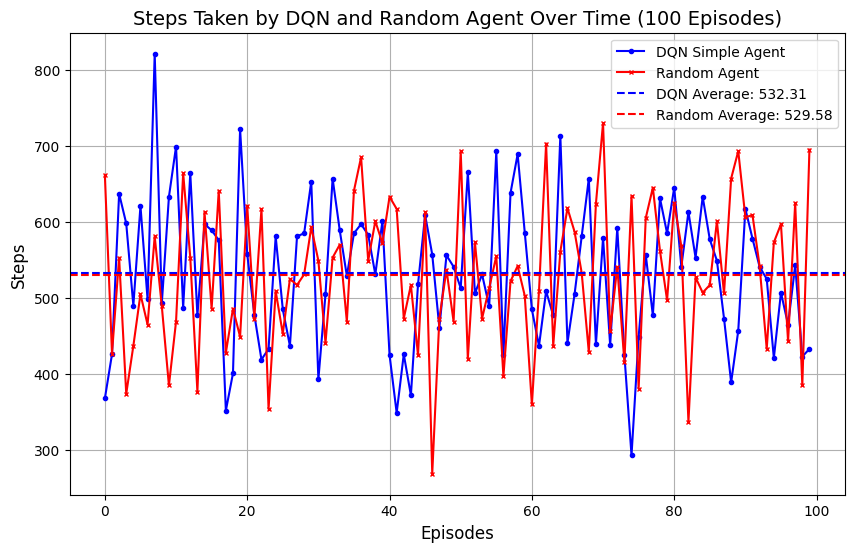

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(steps_run_simple, marker='o', linestyle='-', color='b', markersize=3, label='DQN Simple Agent')
plt.plot(steps_random, marker='x', linestyle='-', color='r', markersize=3, label='Random Agent')
plt.title('Steps Taken by DQN and Random Agent Over Time (100 Episodes)', fontsize=14)
plt.xlabel('Episodes', fontsize=12)
plt.ylabel('Steps', fontsize=12)
avg_dqn = np.mean(steps_run_simple)
avg_random = np.mean(steps_random)
plt.axhline(avg_dqn, color='b', linestyle='--', label=f'DQN Average: {avg_dqn:.2f}')
plt.axhline(avg_random, color='r', linestyle='--', label=f'Random Average: {avg_random:.2f}')

plt.legend()
plt.grid(True)
plt.show()

## Add a "staying alive" reward, train

In [4]:
env = gym.make("ALE/Tetris-v5", obs_type="grayscale")

def crop_state(state):
    return state[25:-5, 20:-95]
    
initial_state, _ = env.reset()
cropped_state = crop_state(initial_state)
state_dim = cropped_state.shape[0] * cropped_state.shape[1]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim)
rewards_simple = []
steps_simple = []

for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    state = crop_state(state)
    episode_reward = 0
    step_count = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = crop_state(next_state)

        if not done:
            reward += STAY_ALIVE_BONUS

        agent.store_experience(state, action, reward, next_state, done)
        agent.train()

        episode_reward += reward
        agent.steps += 1
        step_count += 1
        state = next_state

        if done or step_count >= MAX_STEPS_PER_EPISODE:
            rewards_simple.append(episode_reward)
            steps_simple.append(step_count)
            break

print("Training is complete.")

torch.save(agent.policy_net.state_dict(), "dqn_tetris_stay_alive.pth")
env.close()

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


Training is complete.


## Evaluate the stay alive agent

In [5]:
agent = DQNAgent(state_dim, action_dim)

agent.policy_net.load_state_dict(torch.load("dqn_tetris_stay_alive.pth"))
agent.policy_net.eval()

episode = 0
max_ep = 100
steps_run_stay = []
reward_run_stay = []

while episode < max_ep:
    state, _ = env.reset()
    state = crop_state(state)
    episode_reward = 0
    step_count = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = crop_state(next_state)
        
        episode_reward += reward
        step_count += 1
        state = next_state

        if done:
            steps_run_stay.append(step_count)
            reward_run_stay.append(episode_reward)
            episode += 1
            break
    
    print(f"Episode {episode}: {episode_reward} reward and {step_count} steps.")

    env.close()

Episode 1: 0.0 reward and 513 steps.
Episode 2: 0.0 reward and 585 steps.
Episode 3: 0.0 reward and 654 steps.
Episode 4: 0.0 reward and 376 steps.
Episode 5: 0.0 reward and 629 steps.
Episode 6: 0.0 reward and 448 steps.
Episode 7: 0.0 reward and 805 steps.
Episode 8: 0.0 reward and 548 steps.
Episode 9: 0.0 reward and 573 steps.
Episode 10: 0.0 reward and 341 steps.
Episode 11: 0.0 reward and 657 steps.
Episode 12: 0.0 reward and 607 steps.
Episode 13: 0.0 reward and 569 steps.
Episode 14: 0.0 reward and 581 steps.
Episode 15: 1.0 reward and 776 steps.
Episode 16: 0.0 reward and 489 steps.
Episode 17: 0.0 reward and 695 steps.
Episode 18: 0.0 reward and 697 steps.
Episode 19: 0.0 reward and 405 steps.
Episode 20: 0.0 reward and 553 steps.
Episode 21: 0.0 reward and 533 steps.
Episode 22: 0.0 reward and 489 steps.
Episode 23: 0.0 reward and 522 steps.
Episode 24: 0.0 reward and 465 steps.
Episode 25: 0.0 reward and 667 steps.
Episode 26: 0.0 reward and 413 steps.
Episode 27: 0.0 rewar

## Watch stay alive play

In [6]:
agent.policy_net.load_state_dict(torch.load("dqn_tetris_stay_alive.pth"))
agent.policy_net.eval()
env = gym.make("ALE/Tetris-v5", obs_type="grayscale", render_mode="human")

done = False
steps = 0
state, _ = env.reset()
state = crop_state(state)

while not done:
    env.render()
    action = agent.select_action(state)
    next_state, reward, done, _, _ = env.step(action)
    next_state = crop_state(next_state)

    if reward == 1:
        print("CLEARED A ROW!!!!!")
    
    steps += 1

env.close()

## Compare steps for random vs staying alive agent

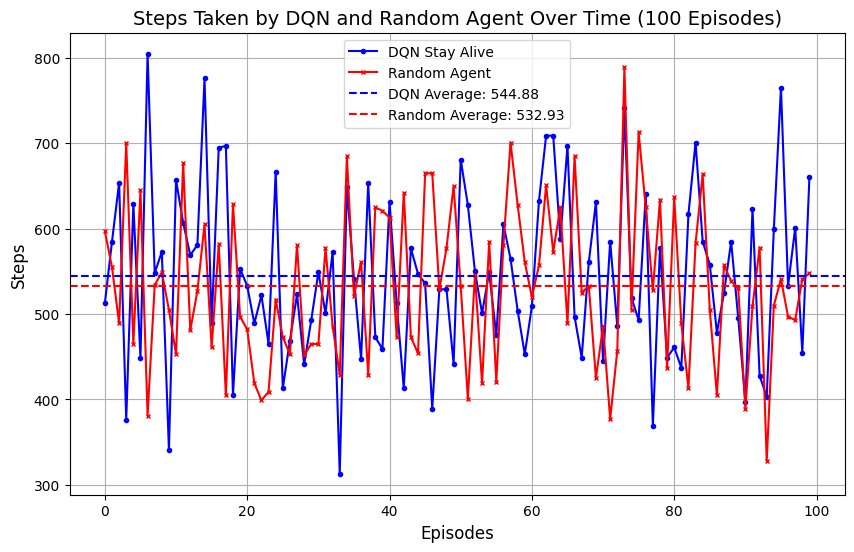

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(steps_run_stay, marker='o', linestyle='-', color='b', markersize=3, label='DQN Stay Alive')
plt.plot(steps_random, marker='x', linestyle='-', color='r', markersize=3, label='Random Agent')
plt.title('Steps Taken by DQN and Random Agent Over Time (100 Episodes)', fontsize=14)
plt.xlabel('Episodes', fontsize=12)
plt.ylabel('Steps', fontsize=12)
avg_dqn = np.mean(steps_run_stay)
avg_random = np.mean(steps_random)
plt.axhline(avg_dqn, color='b', linestyle='--', label=f'DQN Average: {avg_dqn:.2f}')
plt.axhline(avg_random, color='r', linestyle='--', label=f'Random Average: {avg_random:.2f}')

plt.legend()
plt.grid(True)
plt.show()

## Citations / References
- ChatGPT was of great help to create the graphs that show the step counts for the random/DQN agents. I am not as experienced with matplotlib so it was helpful in helping me to construct an informative, well-labeled graph. My prompt was that I had two lists of episodes/steps and I wanted to compare them over the episodes. 
- [The ALE environment documentation was also used for imports, actions, observations, and running the environment.](https://ale.farama.org/environments/tetris/)
- ChatGPT helped with tensors and the DQN agent (specifically the relationship between those two). Assignment 4 code was also referenced for the DQN Agent. 